# Sentiment Analysis with ParsBERT

## The NVIDIA System Management Interface (nvidia-smi) is a command line utility, based on top of the NVIDIA Management Library (NVML), intended to aid in the management and monitoring of NVIDIA GPU devices.

In [1]:
!nvidia-smi
!pip install hazm
!pip install textacy
!pip install -q transformers

Sun Jun 12 10:46:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install & import Libraries

In [2]:
# Import required packages (If You Need Any More Packages, You Can Add them HERE.)

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import collections
import hazm
import plotly.graph_objects as go
import json
import copy

## Dataset

### Load the data

In [3]:
!git clone https://github.com/SBU-CE/Deep-Learning.git
data = pd.read_csv('Deep-Learning/spring-2022/assignments/project-3/taghche_5000.csv', encoding='utf-8')
data = data[['comment', 'rate']]
data.head()
print(data.info(), '\n')

Cloning into 'Deep-Learning'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 414 (delta 64), reused 23 (delta 11), pack-reused 265
Receiving objects: 100% (414/414), 16.43 MiB | 23.57 MiB/s, done.
Resolving deltas: 100% (149/149), done.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  5000 non-null   object
 1   rate     5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB
None 



In [4]:
# handle some conflicts with the dataset structure
# you can find a reliable solution, for the sake of the simplicity
# I just remove these bad combinations!
data['rate'] = data['rate'].apply(lambda r: r if r < 6 else None)

data = data.dropna(subset=['rate'])
data = data.dropna(subset=['comment'])
data = data.drop_duplicates(subset=['comment'], keep='first')
data = data.reset_index(drop=True)
print(data.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4665 entries, 0 to 4664
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  4665 non-null   object
 1   rate     4665 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 73.0+ KB
None 



### Normalization / Preprocessing

**<font color=red> For simplicity, Transform the rate in a range of 0.0 to 5.0 to a binary form of negative (0) or positive (1) with a threshold. If the rate is less than 3.0, it labeled as negative otherwise specified as positive.</font>**

In [5]:
##############################################################################################
data['label']=np.where(data['rate']<3,'Neg','Pos')
#data
data.info()
##############################################################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4665 entries, 0 to 4664
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  4665 non-null   object
 1   rate     4665 non-null   int64 
 2   label    4665 non-null   object
dtypes: int64(1), object(2)
memory usage: 109.5+ KB


**<font color=red> Cleaning is the final step in this section. Your cleaned method should be included these steps:</font>**

**<font color=red>- fixing unicodes</font>**

**<font color=red>- removing specials like a phone number, email, url, new lines, ...</font>**

**<font color=red>- cleaning HTMLs</font>**

**<font color=red>- normalizing</font>**

**<font color=red>- removing emojis</font>**

**<font color=red>- removing extra spaces, hashtags</font>**

In [6]:
import re
import html
import textacy.preprocessing as prep

def cleaning(text):
    text = text.strip()
    
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    text = prep.normalize.hyphenated_words(text)
    text = prep.normalize.quotation_marks(text)
    text = prep.normalize.unicode(text)
    text = prep.normalize.whitespace(text)
    text = prep.normalize.bullet_points(text)
    maxn=0
    text = prep.normalize.repeating_chars(text,chars="ا")
    text = prep.normalize.repeating_chars(text,chars="ـ",maxn=0)  
    text = prep.normalize.repeating_chars(text,chars="ي")
    text = prep.normalize.repeating_chars(text,chars="ی")
    text = prep.remove.accents(text)
    text = prep.remove.brackets(text)
    text = prep.remove.html_tags(text)
    text = prep.remove.punctuation(text)
    text = prep.replace.emojis(text,' ')
    text = prep.replace.emails(text,' ')
    text = prep.replace.hashtags(text,' ')
    #text = prep.replace.numbers(text,' ')
    text = prep.replace.phone_numbers(text,' ')
    text = prep.replace.urls(text,' ')
    text = prep.replace.user_handles(text,' ')
    return text.strip()
       
    

In [7]:
# cleaning comments
data['cleaned_comment'] = data['comment'].apply(cleaning)
data
with open('tesst.txt', 'w', encoding = 'utf-8') as f:
    for rec_index, rec in data.iterrows():
        f.write(rec['comment']+'\n\n'+rec['cleaned_comment'] + '\n\n')
#data.to_csv(r'pandas.txt', header=None, index=None, sep='f', mode='w')

**<font color=red> Calculate the Length of Comments based on their Words</font>**

In [8]:
##############################################################################################
def word_count(text): 
    nw = len(text.split())
    return(nw)

data['n_word']=data['cleaned_comment'].apply(word_count)


**<font color=red> Remove Comments with the Length of Fewer than 3 Words & More than 256 Words</font>**

In [9]:
##############################################################################################
data = data.loc[data['n_word'] >2]
data = data.loc[data['n_word'] <257]
data = data.reset_index(drop=True)
data.info()  

with open('tesst1.txt', 'w', encoding = 'utf-8') as f:
    for rec_index, rec in data.iterrows():
        f.write(rec['comment']+'\n\n'+rec['cleaned_comment'] + '\n\n')
      
##############################################################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   comment          4284 non-null   object
 1   rate             4284 non-null   int64 
 2   label            4284 non-null   object
 3   cleaned_comment  4284 non-null   object
 4   n_word           4284 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 167.5+ KB


In [10]:
data = data[['cleaned_comment', 'label']]
data.columns = ['comment', 'label']
data.head()

,comment,label
0,اسم کتاب No one writes to the Colonel ترجمش می...,Neg
1,طاقچه عزیز نام کتاب کسی به سرهنگ نامه نمینویسد...,Pos
2,بنظرم این اثر مارکز خیلی از صد سال تنهای که بخ...,Pos
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,Neg
4,کتاب خوبی است,Pos


### Handling Unbalanced Data

**<font color=red> Because the Data is Unbalanced, You should Balance it. Before & After Balancing Data, You should Plot a Bar Chart of Distribution of label within comments [DATA]</font>**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  4284 non-null   object
 1   label    4284 non-null   object
dtypes: object(2)
memory usage: 67.1+ KB


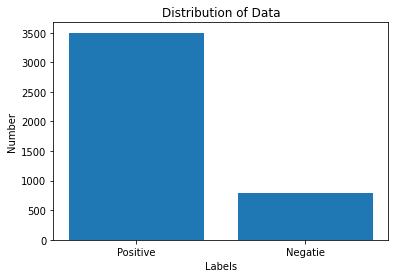

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4704 entries, 0 to 4703
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  4704 non-null   object
 1   label    4704 non-null   object
dtypes: object(2)
memory usage: 73.6+ KB


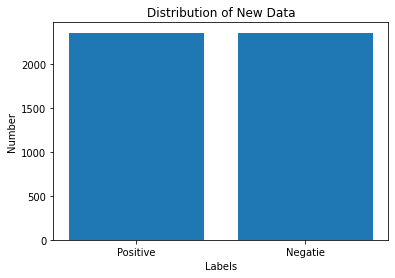

In [11]:
##############################################################################################
import matplotlib.pyplot as plt

data.info()
N_pos=sum(data['label'] == 'Pos')
N_neg=sum(data['label'] == 'Neg')   

height = [N_pos, N_neg]
bars = ('Positive', 'Negatie')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.title('Distribution of Data')
plt.ylabel('Number')
plt.xlabel('Labels')
plt.show()

data_neg=data[data['label']=='Neg']
data_pos=data[data['label']=='Pos']

min_len=min(N_pos, N_neg)

if min_len== N_neg:
    data_neg = data_neg.sample(frac=3, replace=True, random_state=1)

if min_len<= N_pos:
    data_pos = data_pos.sample(n=min_len * 3).reset_index(drop=True)

new_data = pd.concat([data_neg, data_pos])
new_data = new_data.sample(frac=1).reset_index(drop=True)
new_data.info()

a1=sum(new_data['label'] == 'Pos')
a2=sum(new_data['label'] == 'Neg')   

height = [a1, a2]
bars = ('Positive', 'Negatie')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.title('Distribution of New Data')
plt.ylabel('Number')
plt.xlabel('Labels')
plt.show()

##############################################################################################

## Train,Validation,Test split

To achieve a globalized model, we need to split the cleaned dataset into train, valid, test sets due to size of the data. In this tutorial, I have considered a rate of **0.1** for both *valid*, *test* sets. For splitting, I use `train_test_split` provided by Sklearn package with stratifying on the label for preserving the distribution balance.

In [12]:
labels = list(sorted(data['label'].unique()))

new_data['label_id'] = new_data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(new_data, test_size=0.1, random_state=1, stratify=new_data['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(3809, 3)
(424, 3)
(471, 3)


![BERT INPUTS](https://res.cloudinary.com/m3hrdadfi/image/upload/v1595158991/kaggle/bert_inputs_w8rith.png)

As you may know, the BERT model input is a combination of 3 embeddings.
- Token embeddings: WordPiece token vocabulary (WordPiece is another word segmentation algorithm, similar to BPE)
- Segment embeddings: for pair sentences [A-B] marked as $E_A$ or $E_B$ mean that it belongs to the first sentence or the second one.
- Position embeddings: specify the position of words in a sentence

## PyTorch

In [13]:
# Import required packages (If You Need Any More Packages, You Can Add them HERE.)

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AdamW
from transformers import BertConfig, BertTokenizer
from transformers import BertModel
from transformers import AutoConfig, AutoTokenizer, AutoModel


### Configuration

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [15]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 2e-5
CLIP = 0.0
OUTPUT_PATH = 'bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [16]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')



label2id: {'Neg': 0, 'Pos': 1}
id2label: {0: 'Neg', 1: 'Pos'}


**<font color=red> Setup the Tokenizer and Configuration</font>**

In [17]:
##############################################################################################
# setup the tokenizer and configuration
tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
config = BertConfig.from_pretrained(
    "HooshvareLab/bert-base-parsbert-uncased", **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

idx = np.random.randint(0, len(train))
sample_comment = train.iloc[idx]['comment']
sample_label = train.iloc[idx]['label']

print(f'Sample: \n{sample_comment}\n{sample_label}')
encoding = tokenizer.encode_plus(
    sample_comment,
    max_length=32,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')
    
    
##############################################################################################

Downloading:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Neg",
    "1": "Pos"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Neg": 0,
    "Pos": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}

Sample: 
متنش جذابه اما خیلی به صادق هدایت و بوف کور و سه قطره خون توهین کرده و مخصوصا مسیو و هدایتعلی خان واقعا خیلی جنبه توهین داشت و ای کاش تو اخر محمودخان و بلقیس به یکدیگر می رسیدند و رحیم هم از اون دارالمجانین در میومد
Neg
Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[    2, 91403,  5275,

### Input Embeddings

### Dataset

In [18]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [19]:
label_list = ['Neg', 'Pos']
train_data_loader = create_data_loader(train['comment'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['comment'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['comment'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

### Model

**<font color=red> Complete forward function</font>**

In [20]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        ##############################################################################################
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids, return_dict=False)
        
        pooled_output = self.dropout(pooled_output)
        output = self.classifier(pooled_output)
        return output                                         #
        ##############################################################################################
        

In [21]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Sun Jun 12 10:48:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


### Training

**<font color=red> Complete functions</font>**

In [23]:
 # Define Accuracy and F1-score
    ##############################################################################################
def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = (y_true==y_pred).mean()
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }                                  #
    ##############################################################################################
  
def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader),disable=True, desc="Evaluation... "):

            # Define input_ids, attention_mask, token_type_ids, targets
            ##############################################################################################
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']
      ##############################################################################################
            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)
            # compute predicted outputs by passing inputs to the model
            ##############################################################################################
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            ##############################################################################################
             # convert output probabilities to predicted class
            ##############################################################################################
            _, preds = torch.max(outputs, dim=1)                                            
            ##############################################################################################
            # calculate the batch loss
            ##############################################################################################
            loss = loss_fn(outputs, targets)                                     
            ##############################################################################################
            # accumulate all the losses
            losses.append(loss.item())
            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss

def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader),disable=True, desc="Training... "):
        step += 1

        # Define input_ids, attention_mask, token_type_ids, targets
        ##############################################################################################
        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']                                     #
        ##############################################################################################

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        ##############################################################################################
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)                                         #
        ##############################################################################################
        
        # convert output probabilities to predicted class
        ##############################################################################################
        _, preds = torch.max(outputs, dim=1)                                           #
        ##############################################################################################

        # calculate the batch loss
        ##############################################################################################
        loss = loss_fn(outputs, targets)                                          #
        ##############################################################################################

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
               eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
               eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                ##if hasattr(eval_cb, '__call__'):
               eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

**<font color=red> Define Optimizer, Scheduler & Loss Function</font>**

In [24]:
#######################################Your Code#############################################
!pip install pytorch_pretrained_bert==0.4.0
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()
                                                                            
##############################################################################################

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)

def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        ##if eval_loss <= eval_loss_min:
        #print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                #eval_loss_min,
                #eval_loss))
            
        torch.save(model.state_dict(), output_path)
        eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 1.9 MB/s 
     |████████████████████████████████| 132 kB 8.8 MB/s 
     |████████████████████████████████| 8.9 MB 63.2 MB/s 
     |████████████████████████████████| 79 kB 7.9 MB/s 
     |████████████████████████████████| 138 kB 80.9 MB/s 
     |████████████████████████████████| 127 kB 64.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


**<font color=red> Complete Training & Plot Loss and Accuracy Diagram</font>**

Epochs... :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15...Step: 150...Train Loss: 0.566699...Train Acc: 0.714...Valid Loss: 0.432379...Valid Acc: 0.807...
Epoch: 2/15...Step: 300...Train Loss: 0.287495...Train Acc: 0.897...Valid Loss: 0.421778...Valid Acc: 0.847...
Epoch: 2/15...Step: 450...Train Loss: 0.227527...Train Acc: 0.925...Valid Loss: 0.314471...Valid Acc: 0.882...
Epoch: 3/15...Step: 600...Train Loss: 0.114463...Train Acc: 0.968...Valid Loss: 0.394735...Valid Acc: 0.877...
Epoch: 4/15...Step: 750...Train Loss: 0.114975...Train Acc: 0.966...Valid Loss: 0.368966...Valid Acc: 0.884...
Epoch: 4/15...Step: 900...Train Loss: 0.060837...Train Acc: 0.984...Valid Loss: 0.439339...Valid Acc: 0.889...
Epoch: 5/15...Step: 1050...Train Loss: 0.051792...Train Acc: 0.985...Valid Loss: 0.571431...Valid Acc: 0.887...
Epoch: 6/15...Step: 1200...Train Loss: 0.044778...Train Acc: 0.988...Valid Loss: 0.413795...Valid Acc: 0.899...
Epoch: 6/15...Step: 1350...Train Loss: 0.022622...Train Acc: 0.993...Valid Loss: 0.412258...Valid Acc: 0.908..

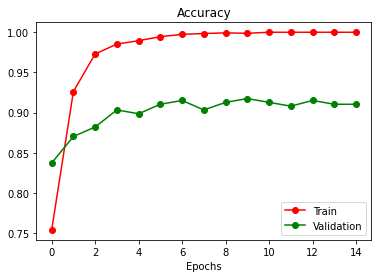

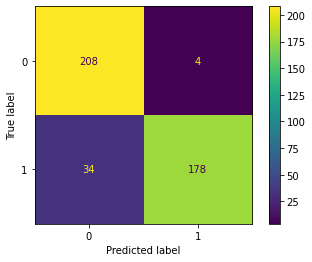

In [25]:
CLIP=0.0
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=150, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
        ##############################################################################################
    
    # Define train_score using acc_and_f1
    ##############################################################################################
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
                                             #
    ##############################################################################################
    
    # Define eval_y, eval_loss using eval_op
    ##############################################################################################
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)                                           #
    ##############################################################################################
    
    # Define eval_score using acc_and_f1
    ##############################################################################################
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')                                     #
    ##############################################################################################
    
    # Save Accuracy and Loss values
    ##############################################################################################
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)                                        #
    ##############################################################################################


# Diagram
##############################################################################################
##### Accuracy Diagram
plt.figure()
plt.plot(history['train_acc'], "ro-", label="Train")
plt.plot(history['val_acc'], "go-", label="Validation")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epochs")   
   

#######Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true1= torch.tensor(eval_y[0], device = 'cpu')
y_pred1=torch.tensor(eval_y[1], device = 'cpu')

CM=confusion_matrix(y_true1, y_pred1, labels=[0, 1])                            #
disp = ConfusionMatrixDisplay(confusion_matrix=CM,display_labels=[0, 1])
disp.plot()


##############################################################################################

### Prediction

**<font color=red> Complete function</font>**

In [26]:
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):

            # Define input_ids, attention_mask, token_type_ids
            ##############################################################################################
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']                                          #
            ##############################################################################################

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            ##############################################################################################
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)                                           #
            ##############################################################################################
            
            # convert output probabilities to predicted class
            ##############################################################################################
            _, preds = torch.max(outputs, dim=1)
                                             #
            ##############################################################################################

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [27]:
test_comments = test['comment'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=128)

print(preds.shape, probs.shape)

  0%|          | 0/15 [00:00<?, ?it/s]

(471,) (471, 2)


**<font color=red> Evaluate Your Model using f1-score & Precision & Recall</font>**

In [28]:
##############################################################################################
y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds

print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print()
print(classification_report(y_test, y_pred, target_names=label_list))                         #
##############################################################################################

F1: 0.9170404033085319

              precision    recall  f1-score   support

         Neg       0.88      0.96      0.92       235
         Pos       0.96      0.87      0.91       236

    accuracy                           0.92       471
   macro avg       0.92      0.92      0.92       471
weighted avg       0.92      0.92      0.92       471

